# Lab3 - Training Deep Convolutional Neural Network
- Papin Thanutchapat, 62070505209
- Chiraphat Phoncharoenwirote, 62070505235

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [ ]:
#import libralies

from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

In [ ]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features, verbose=True)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

#1.Prepare Traning Data
reference : https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification/notebook#Create-Testing-Generator

In [ ]:
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip

--2022-03-22 16:57:50--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  73.1MB/s    in 7.1s    

2022-03-22 16:57:57 (78.1 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
# move all images into Cat_Dog_data

!mv /content/Cat_Dog_data/test/cat/* /content/Cat_Dog_data
!mv /content/Cat_Dog_data/test/dog/* /content/Cat_Dog_data
!mv /content/Cat_Dog_data/train/cat/* /content/Cat_Dog_data
!mv /content/Cat_Dog_data/train/dog/* /content/Cat_Dog_data

In [ ]:
# Prepare Traning Data
import pandas as pd 

filenames = os.listdir("/content/Cat_Dog_data")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({'filename': filenames, 'category': categories })

In [ ]:
df.head()

,filename,category
0,dog.11439.jpg,1
1,dog.1161.jpg,1
2,cat.2068.jpg,0
3,dog.11514.jpg,1
4,dog.5464.jpg,1


In [ ]:
df.describe()

,category
count,25003.00000
mean,0.49994
std,0.50001
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


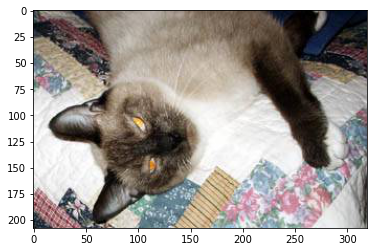

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/Cat_Dog_data/"+sample)
plt.imshow(image)

#2.Split train test

In [ ]:
# change labels from binary to categorical
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
# Split train test
train_df, test_df = train_test_split(df, test_size =0.3, random_state=42)

# Split train validate
train_df, validate_df = train_test_split(df, test_size =0.3, random_state=42)

# 3.Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
# image data generator for train set and validate set
imggen = ImageDataGenerator(rescale=1./255,
                            shear_range=.2, 
                            rotation_range=.2, 
                            width_shift_range=.1,
                            height_shift_range=.1,
                            horizontal_flip = True)

In [ ]:
# image data generator for test set
imggen2 = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define Constants
img_width = 200
img_height = 200
img_channel = 3
img_size = (img_width, img_height)
img_shape = (img_width, img_height, img_channel)
batch_size= 64

In [ ]:
train_set = imggen.flow_from_dataframe(train_df, 
                                             "/content/Cat_Dog_data", 
                                             x_col='filename',
                                             y_col='category',
                                             target_size=img_size, 
                                             class_mode='categorical',
                                             batch_size=batch_size)

Found 17500 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
validate_set = imggen.flow_from_dataframe(validate_df, 
                                             "/content/Cat_Dog_data", 
                                             x_col='filename',
                                             y_col='category',
                                             target_size=img_size, 
                                             class_mode='categorical',
                                             batch_size=batch_size)

Found 7501 validated image filenames belonging to 2 classes.


In [ ]:
test_set = imggen2.flow_from_dataframe(test_df, 
                                             "/content/Cat_Dog_data", 
                                             x_col='filename',
                                             y_col='category',
                                             target_size=img_size, 
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                       shuffle=False)

Found 7500 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
example_df = df.sample(n=1).reset_index(drop=True)
example_generator = imggen.flow_from_dataframe(example_df, 
                                                  "/content/Cat_Dog_data", 
                                                  x_col='filename',
                                                  y_col='category',
                                                  target_size=img_size,
                                                  class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


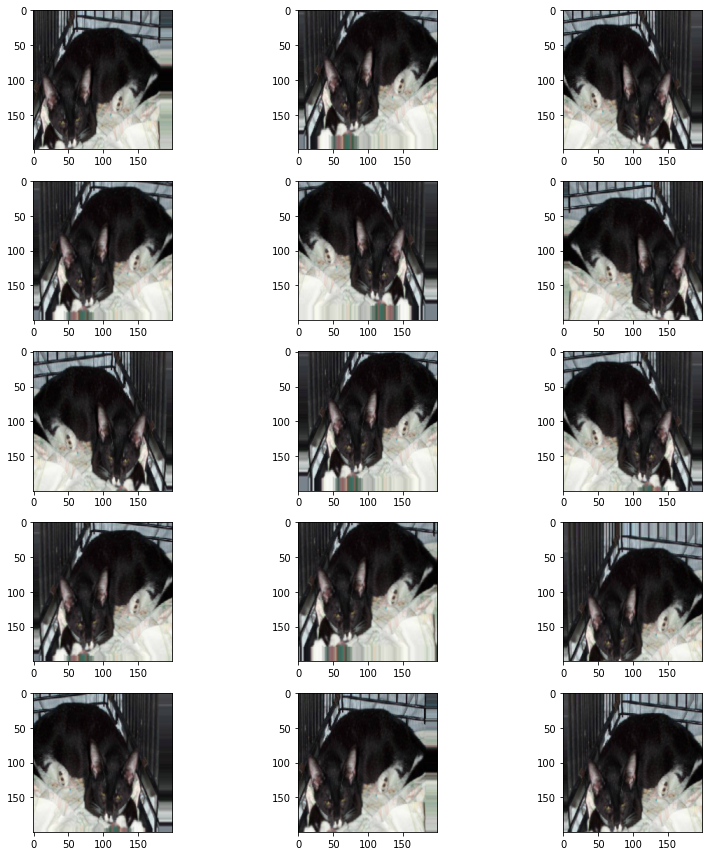

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#4. Build a convolutional neural network

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
#construct custom model
CNN = models.Sequential()
CNN.add(layers.Conv2D(filters= 32,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_1',
                        ))
CNN.add(layers.BatchNormalization())
CNN.add(layers.MaxPooling2D(2,2))
CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(filters= 64,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_2',
                        ))
CNN.add(layers.BatchNormalization())
CNN.add(layers.MaxPooling2D(2,2))

CNN.add(layers.Conv2D(filters= 128,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_3',
                        ))

CNN.add(layers.Conv2D(filters= 256,
                        strides = (2, 2),
                        kernel_size=3,
                        padding='same',
                        activation = 'relu',
                        kernel_initializer='he_uniform',
                        input_shape=img_shape,
                        name = 'conv_4',
                        ))

CNN.add(layers.Flatten())

CNN.add(layers.Dropout(0.22))

CNN.add(layers.Dense(256,activation='relu',
                     kernel_initializer='he_uniform',
                     name='fully_connect_1'
                     ))

CNN.add(layers.Dense(256,activation='relu',
                     kernel_initializer='he_uniform',
                     name='fully_connect_2'
                     ))
CNN.add(layers.Dropout(0.22))

CNN.add(layers.Dense(2,activation='softmax',
                     kernel_initializer='he_uniform',
                     name='output'
                    ))

CNN.compile(optimizer='adam',
           loss = 'binary_crossentropy',
           metrics=['acc'])

CNN.save('savemodel.h5')
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       2

From this pipeline, we use 4 convolutional layers and in each conv_layer. We insert batch normalization layer between first and second , second and third conv_layer used to regularize data. And add dropout layer used to prevent overfitting in the model. After flatten we adding 2 dense layers.


#5.Trainig CNN Model

Epoch 1/50
274/274 [==============================] - 303s 1s/step - loss: 0.6323 - acc: 0.6531 - val_loss: 0.8066 - val_acc: 0.5390 - lr: 0.0010
Epoch 2/50
274/274 [==============================] - 275s 1s/step - loss: 0.5428 - acc: 0.7227 - val_loss: 0.5382 - val_acc: 0.7222 - lr: 0.0010
Epoch 3/50
274/274 [==============================] - 277s 1s/step - loss: 0.4987 - acc: 0.7589 - val_loss: 0.5720 - val_acc: 0.7146 - lr: 0.0010
Epoch 4/50
274/274 [==============================] - 283s 1s/step - loss: 0.4653 - acc: 0.7775 - val_loss: 0.4825 - val_acc: 0.7744 - lr: 0.0010
Epoch 5/50
274/274 [==============================] - 280s 1s/step - loss: 0.4332 - acc: 0.7970 - val_loss: 0.4501 - val_acc: 0.7878 - lr: 0.0010
Epoch 6/50
274/274 [==============================] - 282s 1s/step - loss: 0.4036 - acc: 0.8162 - val_loss: 0.4123 - val_acc: 0.8172 - lr: 0.0010
Epoch 7/50
274/274 [==============================] - 274s 1s/step - loss: 0.3848 - acc: 0.8251 - val_loss: 0.4662 - val_acc

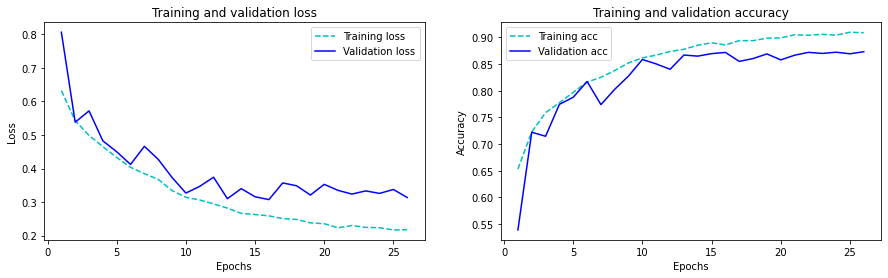

In [ ]:
history = CNN.fit(train_set, batch_size=64, epochs=50, validation_data=validate_set, callbacks=[early_stop, learning_rate_reduction])
CNN.save('cnn.h5')
show_result(history)

#6.Build a VGG16 and Train model
reference : https://www.kaggle.com/code/vipulshinde/dogs-vs-cats-using-custom-cnn-vgg16-model

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model

# Loading the VGG model using Transfer Learning
vgg16_model = VGG16(include_top = False, weights = 'imagenet',input_shape = (200,200,3))

# Freeze all layers in vgg16_model
vgg16_model.trainable = False

# Defining the output layers
# Remove the fully connected layers near the end
flat = Flatten()(vgg16_model.layers[-1].output)
class1 = Dense(units = 256, activation='relu', kernel_initializer='he_uniform', name='fully_connect_1')(flat)
class2 = Dense(units = 256, activation = 'relu', kernel_initializer='he_uniform', name='fully_connect_2')(class1)
output = Dense(units = 2, activation='softmax', kernel_initializer='he_uniform', name='output')(class2)

# define new model
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=output)
vgg16_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)

Epoch 1/50
274/274 [==============================] - 367s 1s/step - loss: 0.3037 - acc: 0.8730 - val_loss: 0.1997 - val_acc: 0.9148 - lr: 0.0010
Epoch 2/50
274/274 [==============================] - 349s 1s/step - loss: 0.2085 - acc: 0.9126 - val_loss: 0.1940 - val_acc: 0.9172 - lr: 0.0010
Epoch 3/50
274/274 [==============================] - 358s 1s/step - loss: 0.1831 - acc: 0.9237 - val_loss: 0.1877 - val_acc: 0.9229 - lr: 0.0010
Epoch 4/50
274/274 [==============================] - 347s 1s/step - loss: 0.1791 - acc: 0.9251 - val_loss: 0.1860 - val_acc: 0.9249 - lr: 0.0010
Epoch 5/50
274/274 [==============================] - 349s 1s/step - loss: 0.1631 - acc: 0.9334 - val_loss: 0.1870 - val_acc: 0.9219 - lr: 0.0010
Epoch 6/50
274/274 [==============================] - ETA: 0s - loss: 0.1564 - acc: 0.9342
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
274/274 [==============================] - 350s 1s/step - loss: 0.1564 - acc: 0.9342 - val_loss: 0.1984

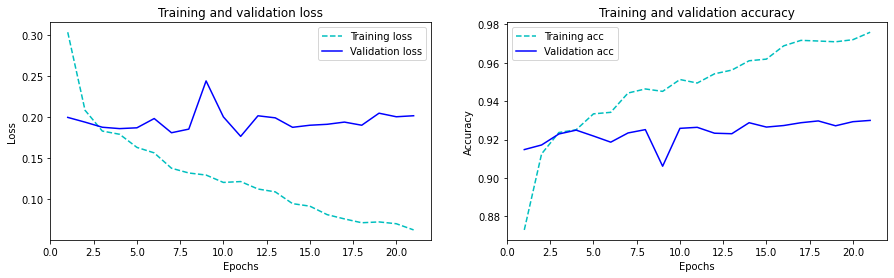

In [ ]:
history2 = vgg16_model.fit(train_set, batch_size=64, epochs=50, validation_data=validate_set, callbacks=[early_stop, learning_rate_reduction])
vgg16_model.save('savemodel2.h5')
show_result(history2)

#7.Build a InceptionV3 and Train model


In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
# Loading the InceptionV3 model using Transfer Learning
incp3_model = InceptionV3(include_top = False, weights = 'imagenet',input_shape = (200,200,3))

# Freeze all layers in incp3_model
incp3_model.trainable = False

# Defining the output layers
# Remove the fully connected layers near the end
flat = Flatten()(incp3_model.layers[-1].output)
class1 = Dense(units = 256, activation='relu', kernel_initializer='he_uniform', name='fully_connect_1')(flat)
class2 = Dense(units = 256, activation = 'relu', kernel_initializer='he_uniform', name='fully_connect_2')(class1)
output = Dense(units = 2, activation='softmax', kernel_initializer='he_uniform', name='output')(class2)

# define new model
incp3_model = Model(inputs=incp3_model.inputs, outputs=output)
incp3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

incp3_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                           

Epoch 1/50
274/274 [==============================] - 320s 1s/step - loss: 0.4238 - acc: 0.9685 - val_loss: 0.1223 - val_acc: 0.9772 - lr: 0.0010
Epoch 2/50
274/274 [==============================] - 352s 1s/step - loss: 0.0780 - acc: 0.9786 - val_loss: 0.0757 - val_acc: 0.9760 - lr: 0.0010
Epoch 3/50
274/274 [==============================] - ETA: 0s - loss: 0.0656 - acc: 0.9810
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
274/274 [==============================] - 301s 1s/step - loss: 0.0656 - acc: 0.9810 - val_loss: 0.0772 - val_acc: 0.9747 - lr: 0.0010
Epoch 4/50
274/274 [==============================] - 304s 1s/step - loss: 0.0441 - acc: 0.9847 - val_loss: 0.0553 - val_acc: 0.9783 - lr: 5.0000e-04
Epoch 5/50
274/274 [==============================] - 299s 1s/step - loss: 0.0401 - acc: 0.9853 - val_loss: 0.0615 - val_acc: 0.9793 - lr: 5.0000e-04
Epoch 6/50
274/274 [==============================] - 305s 1s/step - loss: 0.0397 - acc: 0.9856 - val_loss

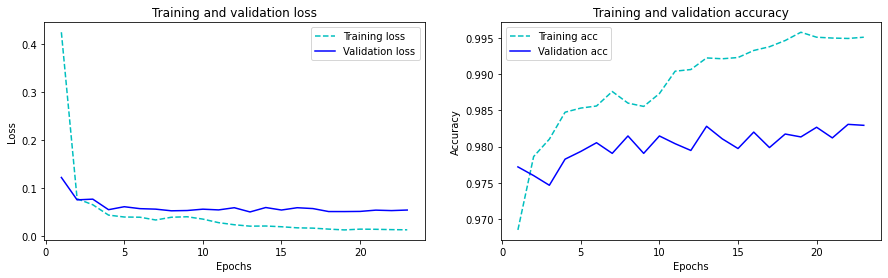

In [ ]:
history3 = incp3_model.fit(train_set, batch_size=64, epochs=50, validation_data=validate_set, callbacks=[early_stop, learning_rate_reduction])
incp3_model.save('savemodel3.h5')
show_result(history3)

#8.Evaluation model


In [ ]:
#change and adap evaluation function from P'Nampetch's code

In [ ]:
# change labels from categorical to binary for use the evaluation_report function
test_df["category"] = test_df["category"].replace({'cat' : 0, 'dog' : 1}) 

In [ ]:
#load model
cnn = models.load_model('cnn.h5')

In [ ]:
evaluation_report(cnn, test_set, test_df['category'])

118/118 [==============================] - 45s 381ms/step - loss: 0.2276 - acc: 0.9044
[[3488  225]
 [ 492 3296]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3713
           1       0.94      0.87      0.90      3788

    accuracy                           0.90      7501
   macro avg       0.91      0.90      0.90      7501
weighted avg       0.91      0.90      0.90      7501

Loss: 0.22761830687522888 Accuracy: 0.9044127464294434


array([1, 0, 1, ..., 1, 0, 1])

From about 91% accuracy, we got 94% of recall for cat task and 94% of precision in dog task. There's got 12% of the model said it
was a cat but it is a dog, and  13% of the real dogs were predicted as a cat by this model


In [ ]:
vgg16 = models.load_model('vgg16.h5')

In [ ]:
evaluation_report(vgg16, test_set, test_df['category'])

118/118 [==============================] - 56s 474ms/step - loss: 0.1013 - acc: 0.9629
[[3614  109]
 [ 169 3609]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3723
           1       0.97      0.96      0.96      3778

    accuracy                           0.96      7501
   macro avg       0.96      0.96      0.96      7501
weighted avg       0.96      0.96      0.96      7501

Loss: 0.10131842643022537 Accuracy: 0.9629382491111755


array([1, 0, 1, ..., 0, 1, 1])

From about 96% accuracy, we got 97% of recall for cat task and 97% of precision in dog task. There's got 4% of the model said it was a cat but it is a dog, and 4% of the real dogs were predicted as a cat by this model

In [ ]:
incp3 = models.load_model('incp3.h5')

In [ ]:
evaluation_report(incp3, test_set, test_df['category'])

118/118 [==============================] - 36s 289ms/step - loss: 0.0518 - acc: 0.9825
[[3623  100]
 [  31 3747]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3723
           1       0.97      0.99      0.98      3778

    accuracy                           0.98      7501
   macro avg       0.98      0.98      0.98      7501
weighted avg       0.98      0.98      0.98      7501

Loss: 0.05178860202431679 Accuracy: 0.9825356602668762


array([1, 0, 1, ..., 1, 1, 1])

From about 98% accuracy, we got 97% of recall for cat task and 97% of precision in dog task. There's got 1% of the model said it was a cat but it is a dog, and 1% of the real dogs were predicted as a cat by this model

#9.Test your Models (Image prediction)
reference : : https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# Define predict function
def predict_catordog(img_path,model):
    img = image.load_img(img_path, target_size=(200, 200))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    pred_class = model.predict(img_preprocessed).argmax(axis =1)

    if pred_class == 0:
      text = 'There is a CAT(s) in this picture!'
    else:
      text = 'There is a DOG(s) in this picture!'
    
    label_to_emoji = ['🐱','🐶']   
    result = label_to_emoji[int(pred_class)]
    
    print('%s %s'%(text,result))

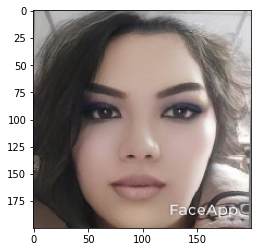

There is a DOG(s) in this picture! 🐶


In [ ]:
predict_catordog('/content/solomon_beauty.png',vgg16)

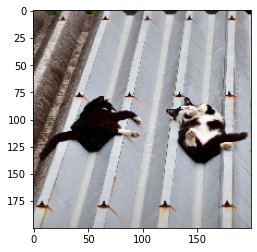

There is a CAT(s) in this picture! 🐱


In [ ]:
predict_catordog('/content/IMG_5796.jpg',incp3)

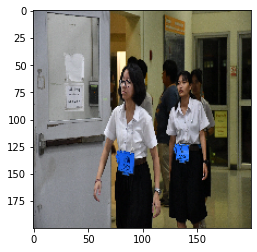

There is a CAT(s) in this picture! 🐱


In [ ]:
predict_catordog('/content/IMG_5796.jpg',cnn)